In [27]:
import implementations
import pandas as pd
import numpy as np
import helpers
import preprocessing

# To create CSV , EXECUTE 1/5 


In [28]:
datapath_train = "./dataset/"
x_train, x_test, y_train, train_ids, test_ids = helpers.load_csv_data(datapath_train)
data_path_names = "./dataset/x_train.csv"
feature_names = np.genfromtxt(data_path_names, max_rows=2, delimiter=",", names=True).dtype.names
feature_names = feature_names[1:]  
columns = np.asarray(feature_names[0:])
# To create CSV , EXECUTE 2/5 

In [29]:
%reload_ext autoreload
%autoreload 2
import preprocessing
import importlib
importlib.reload(preprocessing)
from preprocessing import *
from metrics import *
# To create CSV , EXECUTE 3/5 

In [30]:
x_train_preprocess, x_test_preprocess, y_train = preprocessing.dataPreprocess(x_train, x_test, y_train, columns, feature_names)
x_train_preprocess.shape,x_test_preprocess.shape 
# To create CSV , EXECUTE 4/5 

/Users/antoineschutz/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antoineschutz/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


((328135, 538), (109379, 538))

In [31]:
import cross_validation as cv
import metrics
import matplotlib.pyplot as plt

N = x_train_preprocess.shape[0]
subset_size = N //5
# Generate random indices to select data points for the subset
indices = np.random.choice(len(x_train), subset_size, replace=False)

# Create the random subset from x_train and y_train
x_cv = x_train_preprocess[indices]
y_cv = y_train[indices]

initial_w = -np.ones(x_cv.shape[1])

#initial_w = np.random.normal(0,1,x_test_preprocess.shape[1])

x_cv.shape,y_cv.shape


((65627, 538), (65627,))

In [32]:
def plot_confusion_matrix(actual_y, pred_y, title, ax):
    tp, tn, fp, fn = metrics.calculate_parameters(actual_y, pred_y)
    # Create a confusion matrix plot
    confusion_matrix = [[tn, fp], [fn, tp]]

    im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set_xticks([0, 1], ["Predicted (-1)", "Predicted (1)"])
    ax.set_yticks([0, 1], ["Real value is (-1)", "Real value is (1)"])

    for i in range(2):
        for j in range(2):
            cell_value = confusion_matrix[i][j]
            text_color = 'white' if cell_value > 50000 else 'black'  # Adjust the threshold as needed
            plt.text(j, i, str(confusion_matrix[i][j]), ha='center', va='center', color=text_color, fontsize=16)

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(f"Confusion matrix for {title}")

In [33]:
def find_best_threshold(actual_y, pred_y, model_name, ax):
    
    thresholds = np.arange(-5, 5, 0.1) 
    f1_scores = []  # Store F1 scores for each threshold

    for threshold in thresholds:
        pred_discrete = np.where(pred_y >= threshold, 1, -1)  
        tp, tn, fp, fn = metrics.calculate_parameters(pred_discrete, actual_y)
        f1_score = metrics.f1_score(tp, fp, fn)
        f1_scores.append(f1_score)

    best_threshold = thresholds[np.argmax(f1_scores)]
    
    # Plot F1 scores
    ax.plot(thresholds, f1_scores, label='F1 Score')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('F1 Score')
    ax.set_title(f'F1 Score vs. Threshold for {model_name}')
    ax.axvline(best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
    ax.legend()
    ax.grid(True)

    return best_threshold

/Users/antoineschutz/Documents/GitHub/ml-project-1-ai-ron-team/implementations.py:67: RuntimeWarning: overflow encountered in square
  return 1 / 2 * np.mean(e**2)
/Users/antoineschutz/Documents/GitHub/ml-project-1-ai-ron-team/implementations.py:141: RuntimeWarning: invalid value encountered in subtract
  w = w - gamma * grad


Best gamma value is 0.01
Best Threshold value is -0.5
Best max_iters value is 100
________________________
Average F1 score: 10.11 %
Average accuracy: 65.39 %
________________________


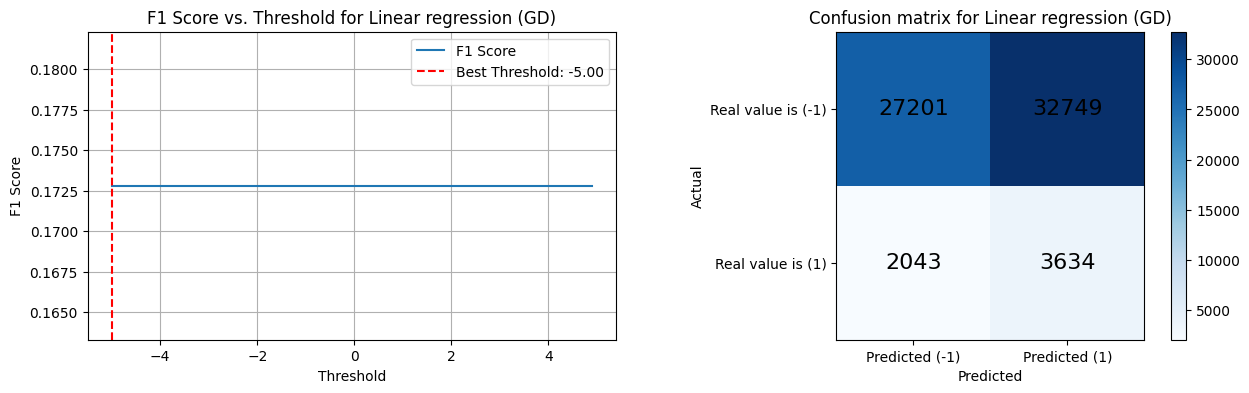

In [34]:
best_max_iters, best_gamma, best_thresh = cv.cross_validation_linear_regression(y_cv, x_cv, sgd=False, max_iters_list=[100,500], gamma_list=[0.01])



w, _ = implementations.mean_squared_error_gd(y_cv, x_cv, initial_w, best_max_iters, best_gamma)
pred = x_cv.dot(w)
pred_discrete = np.where(pred > best_thresh, 1, -1)

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
find_best_threshold(y_cv, pred, "Linear regression (GD)", axs[0])
plot_confusion_matrix(y_cv, pred_discrete, "Linear regression (GD)", axs[1])
plt.show()

Best threshold value is : -0.5
________________________
Average F1 score: 41.82 %
Average accuracy: 88.90 %
________________________


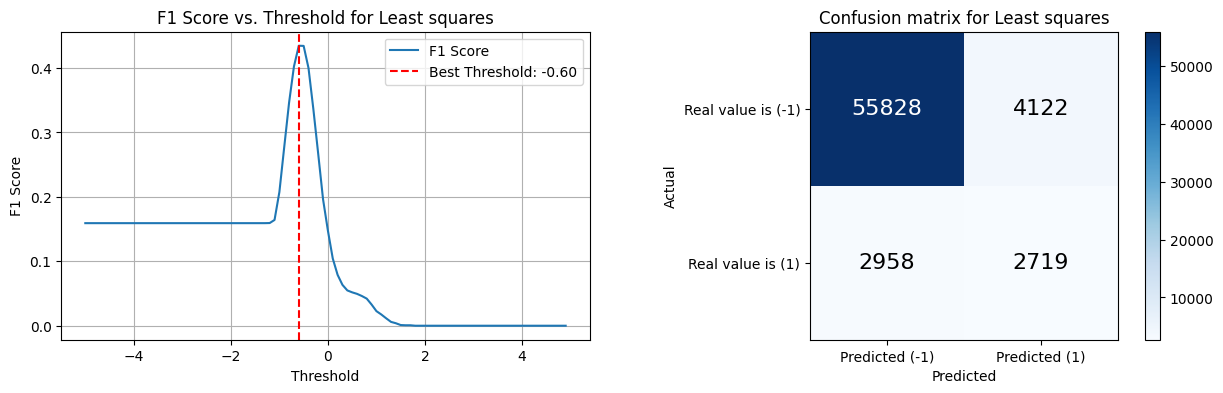

In [35]:
# Least squares
best_thresh = cv.cross_validation_least_squares(y_cv, x_cv)

w, _ = implementations.least_squares(y_cv, x_cv)
pred = x_cv.dot(w)
pred_discrete = np.where(pred >= best_thresh, 1, -1)    

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
find_best_threshold(y_cv, pred, "Least squares", axs[0])
plot_confusion_matrix(y_cv, pred_discrete, "Least squares", axs[1])
plt.show()

Best lambda value is 1e-16
Best threshold value is -0.6
________________________
Average F1 score: 42.09 %
Average accuracy: 85.78 %
________________________


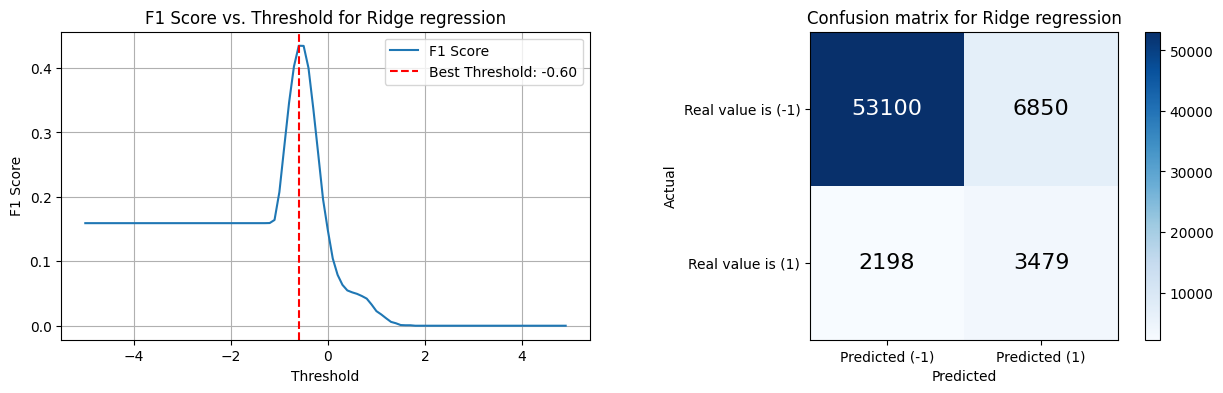

In [39]:
# Ridge regression
best_lambda,best_thresh = cv.cross_validation_ridge_regression(y_cv, x_cv,k=5,threshold=[-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2] ,lambda_values=[1e-16,1e-15,1e-14])

w, _ = implementations.ridge_regression(y_cv, x_cv,best_lambda)
pred = x_cv.dot(w)
pred_discrete = np.where(pred >= best_thresh, 1, -1)

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
find_best_threshold(y_cv, pred, "Ridge regression", axs[0])
plot_confusion_matrix(y_cv, pred_discrete, "Ridge regression", axs[1])
plt.show()

Best gamma value is 0.01
Best max_iters value is 1000
Best Threshold  value is 0.2
________________________
Average F1 score: 19.28 %
Average accuracy: 84.15 %
________________________


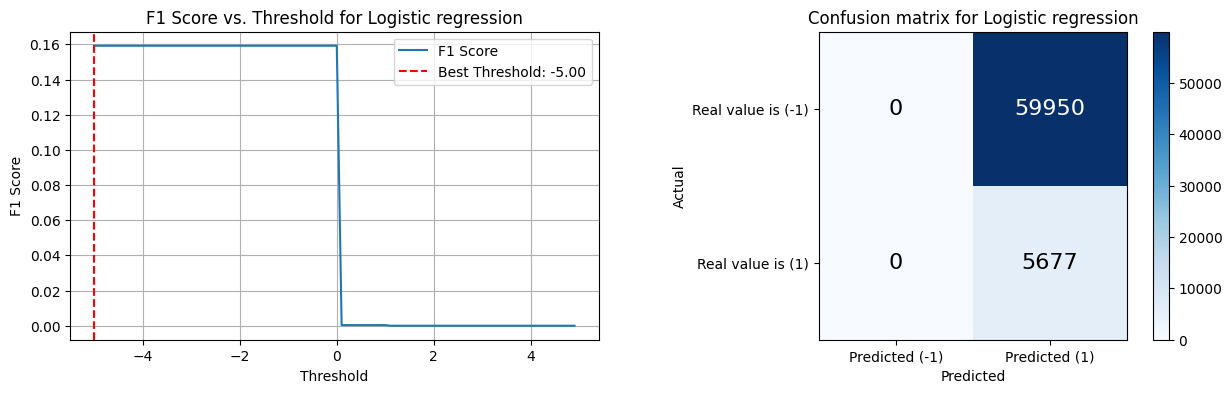

In [37]:
# Logistic regression
import Logistics
y_cv_logistic = (y_cv+1)/2
best_max_ibest_max_iters, best_gamma, best_Threshold = cv.cross_validation_logistic(y_cv_logistic, x_cv, k=5, reg=False, thresholds=[0.5,0.1,0.2], max_iters_list=[1000], gamma_list=[0.01])

w, _ = implementations.logistic_regression(y_cv_logistic, x_cv, initial_w, best_max_iters, best_gamma)
pred = Logistics.sigmoid(x_cv.dot(w))
pred_discrete = np.where(pred >= best_thresh, 1, -1)

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
find_best_threshold(y_cv, pred, "Logistic regression", axs[0])
plot_confusion_matrix(y_cv, pred_discrete, "Logistic regression", axs[1])
plt.show()


In [38]:
# To create CSV , EXECUTE 5/5 

best_lambda =  1e-16
best_Threshold = -0.6

w, _ = implementations.ridge_regression(y_train, x_train_preprocess, best_lambda)
pred = x_test_preprocess.dot(w)
y_pred = np.where(pred >= best_Threshold, 1, -1)


helpers.create_csv_submission(test_ids, y_pred, "final_Submission.csv") # Best submssion , 0.338 f1